# **Merriam-Webster Vocab Definitions**

Use this workbook to input a list of words, and recieve their definitions from Merriam-Webster (https://www.merriam-webster.com/)

# Import Libraries

In [ ]:
# Install tqdm or any missing libraries
!pip install tqdm

In [160]:
#Import Libraries
import requests                         # to make API calls
import re                               # to clean up API response
import csv                              # to generate csv of definitions
from bs4 import BeautifulSoup           # to handle tags in API response
from tqdm.notebook import tqdm          # for a progressbar while execution
from google.colab import userdata       # use: if you are utilizing a Google Colab workbook and store your API Key as a Secret

# Import Input Data

If you have a long list of words you would like to search MW-Dictionary for, enter them in a CSV file with a header.

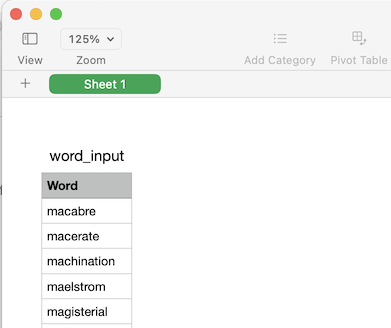

In [161]:
# Path to your CSV file
csv_file_path = 'word_input.csv'

# Initialize an empty list which contains the words
words = []

# Open the CSV file and read words
with open(csv_file_path, mode='r', encoding='utf-8-sig') as csvfile:
    csvreader = csv.reader(csvfile)
    #Skip header
    next(csvreader)
    for row in csvreader:
      #Uses row 0 assuming words are in first col.
        words.append(row[0])

In [163]:
# Alternatively, if you just want to search the meanings of a handful of words,
# comment the previous cell and define a list here:
# words = ['absolve, 'detention, 'frost', 'laugh']

In [162]:
#Check the length of words if all of them were imported correctly
len(words)

995

In [164]:
#Setup Variables

# if your API Key is stored in Colab as a secret named 'apiKey'
MW_API_KEY = userdata.get('apiKey')

# alternatively you could store your API Key in code
#MW_API_KEY = ""

# for reference purposes this is the endpoint provided in M-W API Documentation
ENDPOINT = "https://www.dictionaryapi.com/api/v3/references/collegiate/json/"
# this endpoint can be hit by providing a word and api-key like:, you can paste this in your browser with a word and api key to check
URL = "https://www.dictionaryapi.com/api/v3/references/collegiate/json/word?key=MW_API_KEY"

# Fetch Definitions

In [165]:
# to store final data, used as input for csvwriter
csv_rows = []

# function to clean html tags from the M-W API response
def clean_html(raw_html):
    return BeautifulSoup(raw_html, "html.parser").get_text()

#    function which iterates the 'sense' in which the API response is provided
#    The sense is a key organizational unit of the entry,
#    and gathers together all content relevant to a particular meaning of a headword.
#    (From M-W Documentation)

def parse_sense(sense):
    if 'dt' in sense:
        # extract definition from 'dt'
        for dt in sense['dt']:
            if isinstance(dt, list) and dt[0] == "text":
                return clean_html(dt[1])
    elif isinstance(sense, list):
        # If sense is a list, iterate over its elements
        for item in sense:
            result = parse_sense(item)
            if result:
                return result
    return None

# main function for parsing API response
for word in tqdm(words, desc='Processing Words'):
    response = requests.get(f'https://www.dictionaryapi.com/api/v3/references/collegiate/json/{word}?key={MW_API_KEY}')
    definitions = []
    if response.status_code == 200:
        data = response.json()
        # Check if data is not None & not empty
        if data and data != [None]:
            for entry in data:
                # Additional check to ensure 'entry' is not None
                if entry and 'def' in entry:
                    for sense in entry['def'][0]['sseq']:
                        definition = parse_sense(sense)
                        if definition:
                            definitions.append(definition)
                        if len(definitions) >= 4:  # Limit to first 3-4 definitions
                            break
                    if definitions:
                        break
        else:
            # Handle the case where the API returns [null] or an empty response
            definitions.append('No definition found: null response')
    else:
        definitions.append('Failed to fetch meaning: API error')

    row = [word] + definitions if definitions else [word, 'No definition found']
    csv_rows.append(row)

Processing Words:   0%|          | 0/995 [00:00<?, ?it/s]

<ipython-input-165-a51376501010>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(raw_html, "html.parser").get_text()


# Create Ouput File

In [166]:
# Function to clean up the API output, if beautifulsoup didn't target properly
def clean_definition_text(text):

    text = re.sub(r'\{bc\}', '', text)  # Remove {bc} tags entirely
    text = re.sub(r'\{sx\|([^|]+)\|\|.*?\}', r'\1', text)
    text = re.sub(r'\{[ad]_link\|([^}]+)\}', r'\1', text)
    text = re.sub(r'\{dx\}see \{dxt\|([^:]+):[^|]+\|\|.*?\}\{/dx\}', r'see \1', text)
    text = re.sub(r'\{it\}(.*?){\/it\}', r'\1', text)

    return text.strip()

# Assuming csv_rows is already populated as shown
cleaned_csv_rows = []
for row in csv_rows:
    word = row[0]
    cleaned_definitions = [clean_definition_text(definition) for definition in row[1:]]
    cleaned_csv_rows.append([word] + cleaned_definitions)

# Write to CSV
header = ['Word', 'Definition 1', 'Definition 2', 'Definition 3', 'Definition 4']

with open('mv_definitions.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)

    for row in cleaned_csv_rows:
        # Ensure the row has the correct number of elements
        row_length = len(row)
        expected_length = len(header)

        # If the row is shorter, pad it with empty strings
        if row_length < expected_length:
            row += [''] * (expected_length - row_length)

        # If the row is longer, truncate it to match the expected length
        elif row_length > expected_length:
            row = row[:expected_length]

        writer.writerow(row)

print("CSV file 'mv_definitions.csv' has been created.")

CSV file 'mv_definitions.csv' has been created.
